In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Key Libraries

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import Dataset and split into Training and Test

In [13]:
base_path = '/content/drive/My Drive/Colab Datasets/MSCA_Project_31009_Project/archive/fruits-360_dataset/fruits-360'
#'/content/drive/My Drive/Colab Datasets/MSCA_Project_31009_Project/archive/'
train_path = os.path.join(base_path, 'Training')
test_path = os.path.join(base_path, 'Test')

# Let's see some stats about the dataset
num_classes = len(os.listdir(train_path))
total_images_train = sum([len(files) for r, d, files in os.walk(train_path)])
total_images_test = sum([len(files) for r, d, files in os.walk(test_path)])

print(f'Total number of classes: {num_classes}')
print(f'Total number of training images: {total_images_train}')
print(f'Total number of test images: {total_images_test}')

Total number of classes: 115
Total number of training images: 59759
Total number of test images: 20031


### Exploratory Data Analysis

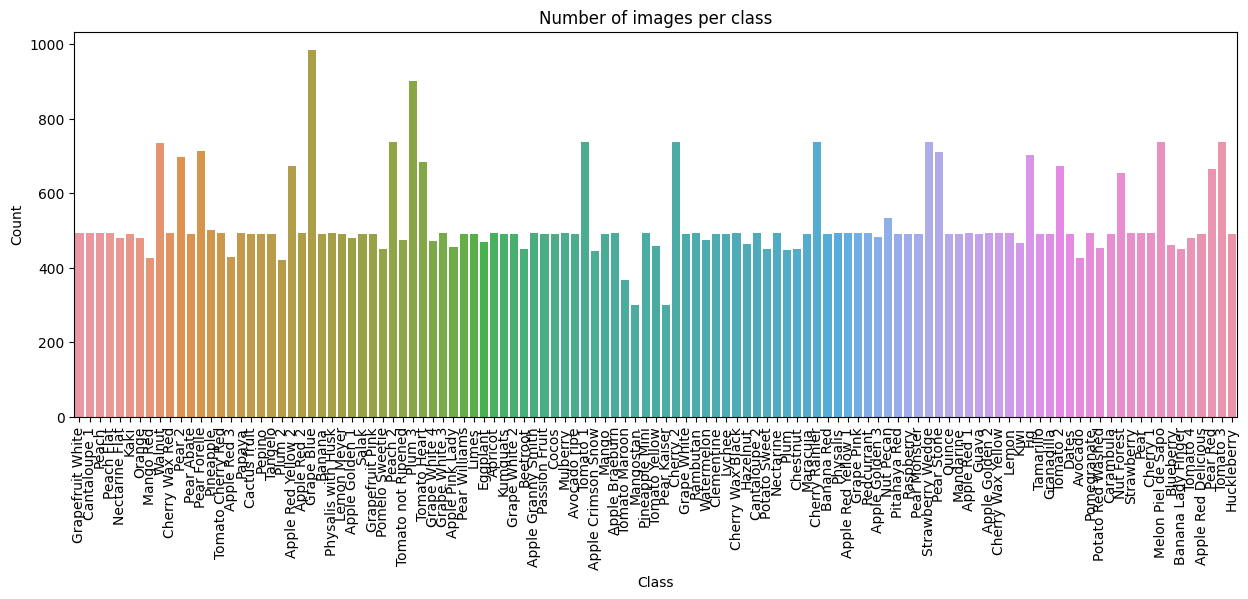

In [14]:
#Step 1: Number of images per class

import seaborn as sns
import pandas as pd

# Count the number of images per class in the training dataset
class_counts = {}

for dir in os.listdir(train_path):
    class_counts[dir] = len(os.listdir(os.path.join(train_path, dir)))

# Display distribution
class_counts_df = pd.DataFrame(list(class_counts.items()),columns = ['Class','Count']) 

plt.figure(figsize=(15,5))
sns.barplot(x="Class", y="Count", data=class_counts_df)
plt.xticks(rotation=90)
plt.title('Number of images per class')
plt.show()


In [15]:
# Step 2: As we noticed a few vegetables are included in the data set, I'll be deleting the same from to make sure to focus on fruit recognition

import shutil

non_fruit_classes = ["Cauliflower", "Corn", "Corn Husk", "Cucumber Ripe", "Cucumber Ripe 2", "Ginger Root",
                     "Kohlrabi", "Onion Red", "Onion Red Peeled", "Onion White", "Pepper Red", "Pepper Green",
                     "Pepper Orange", "Pepper Yellow", "Potato Red", "Potato White"]

# Deleting non fruit directories from training data
for class_name in non_fruit_classes:
    class_path = os.path.join(train_path, class_name)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)

# Deleting non fruit directories from test data
for class_name in non_fruit_classes:
    class_path = os.path.join(test_path, class_name)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)

num_classes = len(os.listdir(train_path))
total_images_train = sum([len(files) for r, d, files in os.walk(train_path)])
total_images_test = sum([len(files) for r, d, files in os.walk(test_path)])

print(f'Total number of classes: {num_classes}')
print(f'Total number of training images: {total_images_train}')
print(f'Total number of test images: {total_images_test}')


Total number of classes: 115
Total number of training images: 59759
Total number of test images: 20031


In [17]:
# Step 3: Reduce the sample size for faster analysis

import shutil

# Define new paths
new_train_path = os.path.join(base_path, 'Modified_Training')
new_test_path = os.path.join(base_path, 'Modified_Test')

# Create these directories
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)


In [18]:

import random

def select_images(original_path, new_path, num_images):
    # For each class in the original directory
    for class_folder in os.listdir(original_path):
        # Get the original class folder path
        class_folder_path = os.path.join(original_path, class_folder)
        
        # Create a new class folder in the new directory
        new_class_folder_path = os.path.join(new_path, class_folder)
        os.makedirs(new_class_folder_path, exist_ok=True)
        
        # Get list of images
        images = os.listdir(class_folder_path)
        
        # Randomly select num_images images
        selected_images = random.sample(images, num_images)
        
        # Copy the selected images to the new class folder
        for image in selected_images:
            shutil.copy(os.path.join(class_folder_path, image), os.path.join(new_class_folder_path, image))


In [19]:

# Number of images you want to keep for each class
num_images_train = 10
num_images_test = 3

# For the training set
select_images(train_path, new_train_path, num_images_train)

# For the test set
select_images(test_path, new_test_path, num_images_test)

# Update paths
train_path = new_train_path
test_path = new_test_path


In [20]:
num_classes = len(os.listdir(train_path))
total_images_train = sum([len(files) for r, d, files in os.walk(train_path)])
total_images_test = sum([len(files) for r, d, files in os.walk(test_path)])

print(f'Total number of classes: {num_classes}')
print(f'Total number of training images: {total_images_train}')
print(f'Total number of test images: {total_images_test}')


Total number of classes: 115
Total number of training images: 2482
Total number of test images: 685


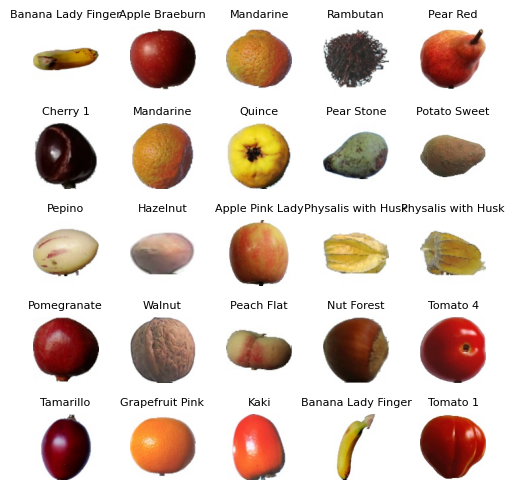

In [21]:
# Step 4: Display some images to have a better understanding of the dataset 

import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np

fig, axs = plt.subplots(5, 5, figsize=(5,5))

for i in range(5):
    for j in range(5):
        # Select a random class
        random_class = random.choice(os.listdir(train_path))
        
        # Select a random image from the chosen class
        random_image = random.choice(os.listdir(os.path.join(train_path, random_class)))
        
        # Create the path to the image file
        img_path = os.path.join(train_path, random_class, random_image)
        img = cv2.imread(img_path)
        
        # Convert the image from BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Add the image to our grid
        axs[i, j].imshow(img)
        axs[i, j].set_title(random_class, fontsize=8)  # reduce font size
        axs[i, j].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

### Feature Engineering & Transformations

In [22]:
# Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define the ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (100, 100)  # Adjust based on the actual image size
batch_size = 32  # Can be adjusted based on your RAM

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 2482 images belonging to 115 classes.
Found 685 images belonging to 115 classes.


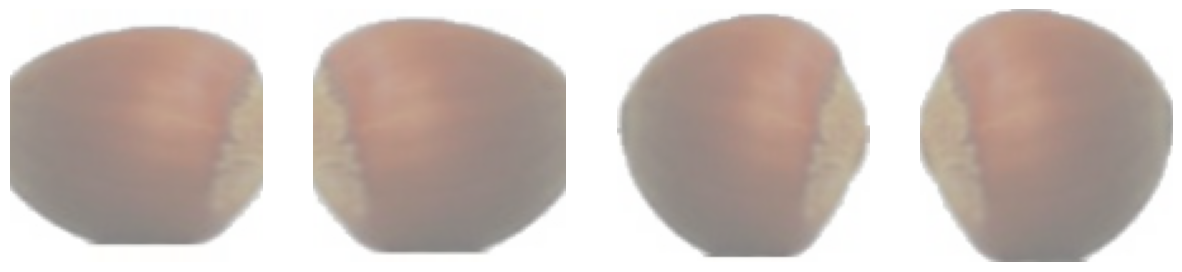

In [23]:
# Import libraries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the target image size
IMG_SIZE = 100  # or any other size that you want

# Select a random fruit class
random_class = random.choice(os.listdir(train_path))

# Select a random image from the chosen class
random_image = random.choice(os.listdir(os.path.join(train_path, random_class)))

# Load the image
img_path = os.path.join(train_path, random_class, random_image)
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (IMG_SIZE, IMG_SIZE, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, IMG_SIZE, IMG_SIZE, 3)

# Randomly transformed images 
i = 0
fig, axs = plt.subplots(1, 4, figsize=(15,15))
for batch in train_datagen.flow(x, batch_size=1):
    axs[i].imshow(batch[0]/2 + 0.5)
    axs[i].axis('off')
    i += 1
    if i % 4 == 0:
        break

plt.show()


## Proposed Approaches (Models) with checks for overfitting/underfitting

#### Model 1 - Convolutional Neural Network (CNN)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history1 = model1.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])

model1.summary()

Epoch 1/20
78/78 [==============================] - 325s 4s/step - loss: 4.5448 - accuracy: 0.0407 - val_loss: 4.0536 - val_accuracy: 0.0686
Epoch 2/20
78/78 [==============================] - 34s 429ms/step - loss: 3.2767 - accuracy: 0.1894 - val_loss: 2.5690 - val_accuracy: 0.3153
Epoch 3/20
78/78 [==============================] - 33s 425ms/step - loss: 2.0479 - accuracy: 0.4174 - val_loss: 1.5604 - val_accuracy: 0.5635
Epoch 4/20
78/78 [==============================] - 35s 447ms/step - loss: 1.3419 - accuracy: 0.5963 - val_loss: 1.1625 - val_accuracy: 0.6701
Epoch 5/20
78/78 [==============================] - 34s 435ms/step - loss: 1.0111 - accuracy: 0.6845 - val_loss: 1.0541 - val_accuracy: 0.6861
Epoch 6/20
78/78 [==============================] - 37s 476ms/step - loss: 0.7391 - accuracy: 0.7732 - val_loss: 0.7469 - val_accuracy: 0.7869
Epoch 7/20
78/78 [==============================] - 33s 428ms/step - loss: 0.6128 - accuracy: 0.8187 - val_loss: 0.7962 - val_accuracy: 0.7591
E

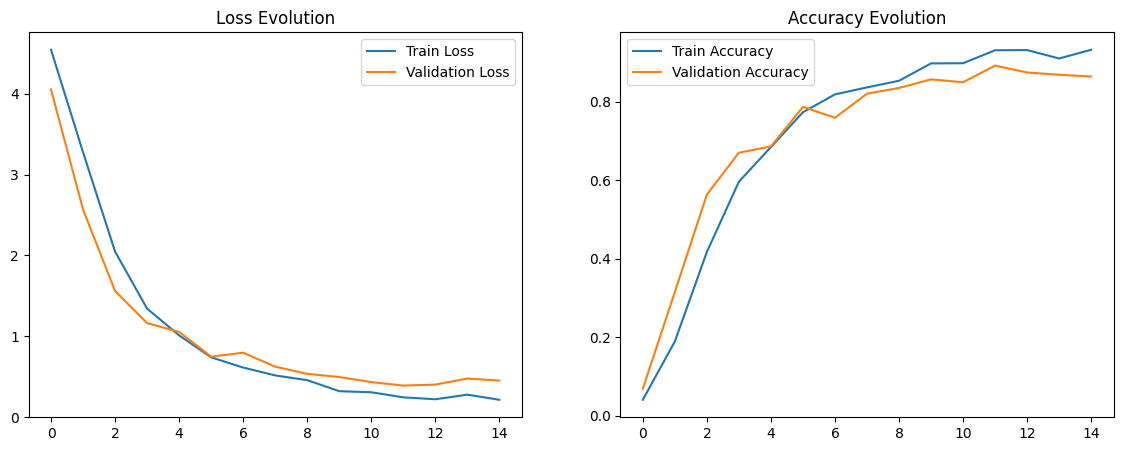

In [25]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()


### Model 2 : VGG16

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

model2 = Sequential()
model2.add(baseModel)
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

# Loop over all layers in the base model and freeze them so they will not be updated during training
for layer in baseModel.layers:
  layer.trainable = False

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])

model2.summary()


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20
36/36 [==============================] - 130s 4s/step - loss: 4.7695 - accuracy: 0.0122 - val_loss: 4.6994 - val_accuracy: 0.0232
Epoch 2/20
36/36 [==============================] - 147s 4s/step - loss: 4.6891 - accuracy: 0.0191 - val_loss: 4.6295 - val_accuracy: 0.0319
Epoch 3/20
36/36 [==============================] - 134s 4s/step - loss: 4.6128 - accuracy: 0.0252 - val_loss: 4.5330 - val_accuracy: 0.0435
Epoch 4/20
36/36 [==============================] - 132s 4s/step - loss: 4.5470 - accuracy: 0.0270 - val_loss: 4.3998 - val_accuracy: 0.0551
Epoch 5/20
36/36 [==============================] - 147s 4s/step - loss: 4.4734 - accuracy: 0.0313 - val_loss: 4.3153 - val_accuracy: 0.0928
Epoch 6/20
36/36 [==============================] - 144s 4s/step - loss: 4.3488 - accuracy: 0.0452 - val_loss: 4.1618 - val_accuracy: 0.1130
Epoch 7/20
36/36 [==============================] - 129s 4s/step - loss: 4.2851 - accurac

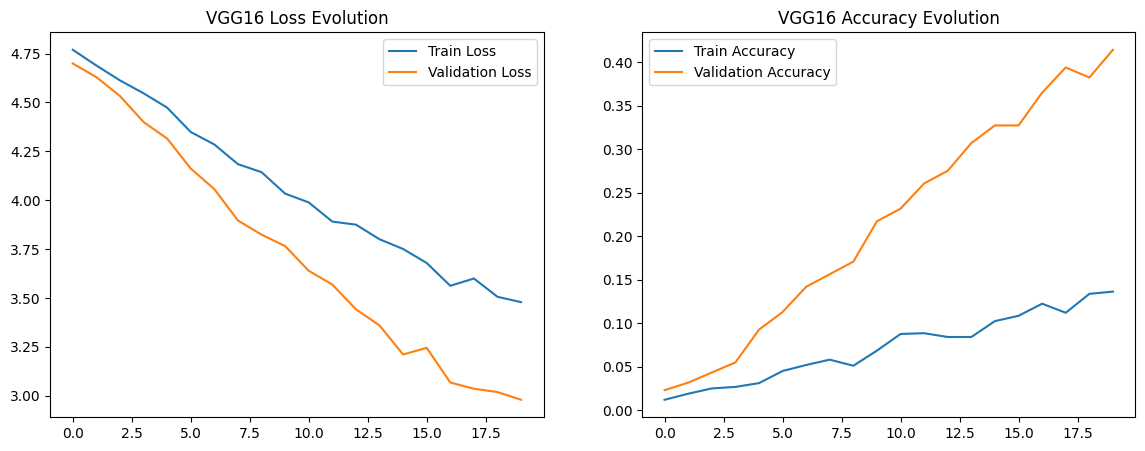

In [21]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('VGG16 Loss Evolution')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('VGG16 Accuracy Evolution')

plt.show()


### Model 3 - ResNet50

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

# Load the ResNet50 network, ensuring the head FC layer sets are left off
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

model4 = Sequential()
model4.add(baseModel)
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

# Loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history4 = model4.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
78/78 [==============================] - 123s 2s/step - loss: 4.8177 - accuracy: 0.0089 - val_loss: 4.7450 - val_accuracy: 0.0088
Epoch 2/20
78/78 [==============================] - 104s 1s/step - loss: 4.7437 - accuracy: 0.0073 - val_loss: 4.7451 - val_accuracy: 0.0088
Epoch 3/20
78/78 [==============================] - 122s 2s/step - loss: 4.7424 - accuracy: 0.0077 - val_loss: 4.7452 - val_accuracy: 0.0088
Epoch 4/20
78/78 [==============================] - 99s 1s/step - loss: 4.7412 - accuracy: 0.0073 - val_loss: 4.7454 - val_accuracy: 0.0088


In [28]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 115)               7475      
                                                                 
Total params: 25,692,403
Trainable params: 2,104,691
Non-trainable params: 23,587,712
_________________________________________________________________


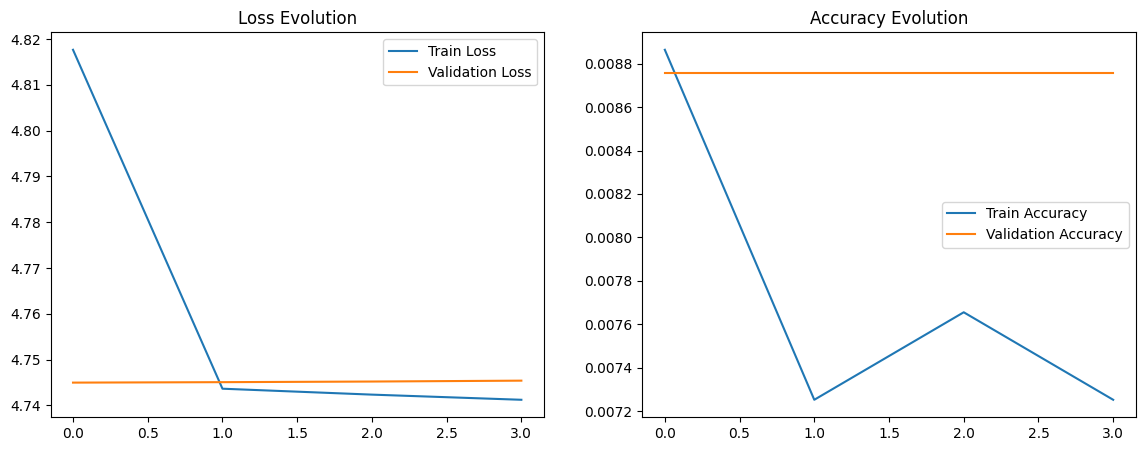

In [29]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

### Model 4 - Convolutional Neural Network with Batch Normalization and additional Convolutional layers

In [30]:
from tensorflow.keras.layers import BatchNormalization

model5 = Sequential()

model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model5.add(BatchNormalization())

model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())

model5.add(Dense(512, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(num_classes, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history5 = model5.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/20
78/78 [==============================] - 157s 2s/step - loss: 3.7065 - accuracy: 0.1624 - val_loss: 8.4764 - val_accuracy: 0.0000e+00
Epoch 2/20
78/78 [==============================] - 163s 2s/step - loss: 2.2563 - accuracy: 0.3803 - val_loss: 8.6294 - val_accuracy: 0.0131
Epoch 3/20
78/78 [==============================] - 158s 2s/step - loss: 1.4942 - accuracy: 0.5649 - val_loss: 10.5688 - val_accuracy: 0.0234
Epoch 4/20
78/78 [==============================] - 156s 2s/step - loss: 1.0912 - accuracy: 0.6970 - val_loss: 14.2434 - val_accuracy: 0.0540


In [31]:
model5.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                      

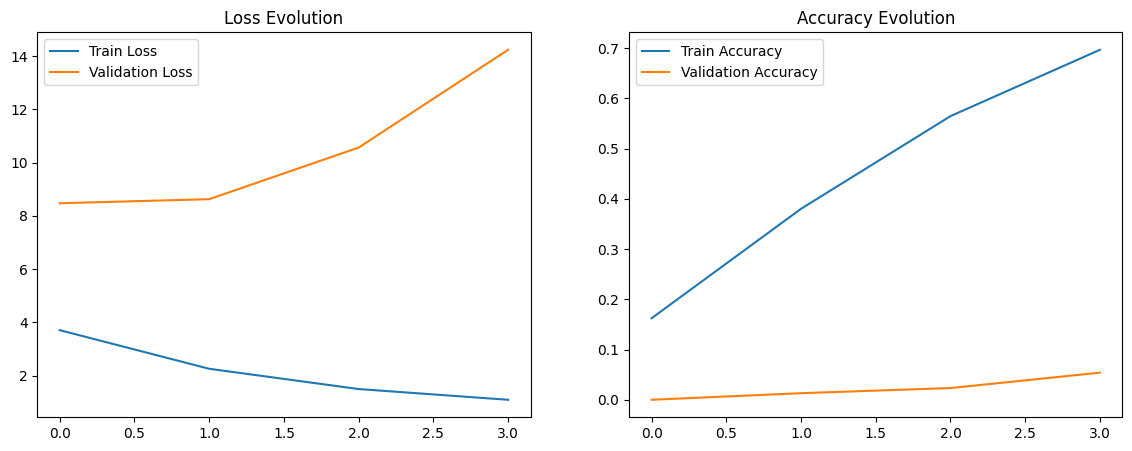

In [32]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()


In [36]:
import pandas as pd

# Create a dictionary with the performance metrics of each model
performance = {
    'Model': ['CNN', 'VGG16', 'ResNet50', 'Advanced_CNN'],
    'Training Accuracy': [
        max(history1.history['accuracy']), 
        max(history2.history['accuracy']),
        max(history4.history['accuracy']),
        max(history5.history['accuracy']),
    ],
    'Validation Accuracy': [
        max(history1.history['val_accuracy']), 
        max(history2.history['val_accuracy']),
        max(history4.history['val_accuracy']),
        max(history5.history['val_accuracy']),
    ],
    'Training Loss': [
        min(history1.history['loss']), 
        min(history2.history['loss']),
        min(history4.history['loss']),
        min(history5.history['loss']),
    ],
    'Validation Loss': [
        min(history1.history['val_loss']), 
        min(history2.history['val_loss']),
        min(history4.history['val_loss']),
        min(history5.history['val_loss']),
    ]
}

# Transform the dictionary into a pandas dataframe
performance_df = pd.DataFrame(performance)
performance_df


,Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,CNN,0.907826,0.805797,0.272310,0.766658
1,VGG16,0.136522,0.414493,3.478587,2.979178
2,ResNet50,0.006087,0.008696,4.745500,4.743595
3,Advanced_CNN,0.562609,0.008696,1.593751,8.171274


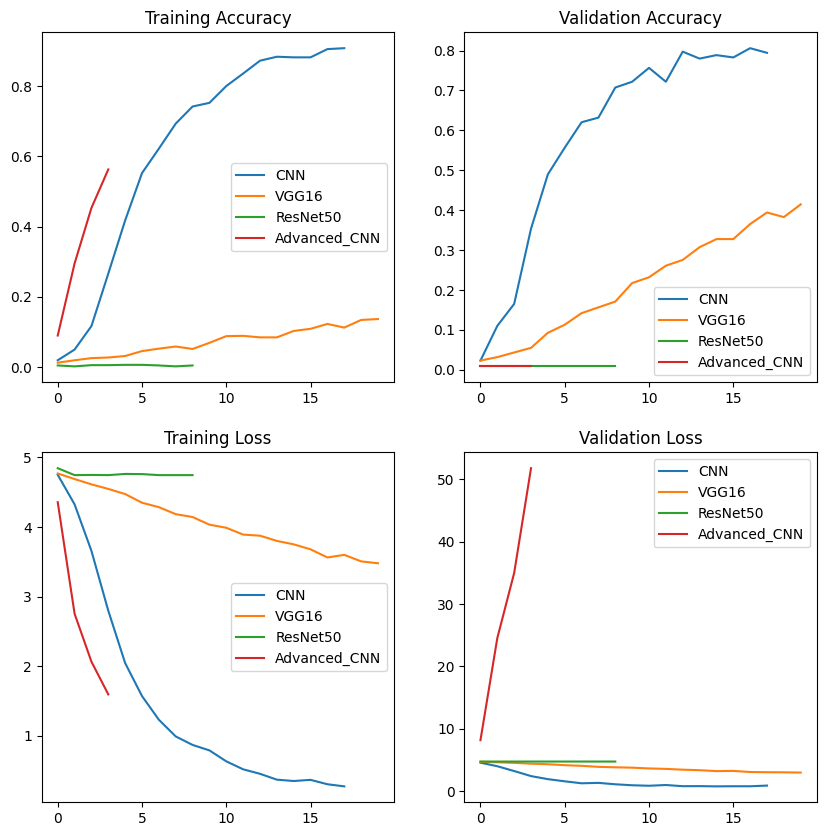

In [42]:
import matplotlib.pyplot as plt

# Setting up the subplots for two graphs
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# Training accuracy
axs[0, 0].plot(history1.history['accuracy'], label='CNN')
axs[0, 0].plot(history2.history['accuracy'], label='VGG16')
axs[0, 0].plot(history4.history['accuracy'], label='ResNet50')
axs[0, 0].plot(history5.history['accuracy'], label='Advanced_CNN')
axs[0, 0].set_title('Training Accuracy')
axs[0, 0].legend()

# Validation accuracy
axs[0, 1].plot(history1.history['val_accuracy'], label='CNN')
axs[0, 1].plot(history2.history['val_accuracy'], label='VGG16')
axs[0, 1].plot(history4.history['val_accuracy'], label='ResNet50')
axs[0, 1].plot(history5.history['val_accuracy'], label='Advanced_CNN')
axs[0, 1].set_title('Validation Accuracy')
axs[0, 1].legend()

# Training loss
axs[1, 0].plot(history1.history['loss'], label='CNN')
axs[1, 0].plot(history2.history['loss'], label='VGG16')
axs[1, 0].plot(history4.history['loss'], label='ResNet50')
axs[1, 0].plot(history5.history['loss'], label='Advanced_CNN')
axs[1, 0].set_title('Training Loss')
axs[1, 0].legend()

# Validation loss
axs[1, 1].plot(history1.history['val_loss'], label='CNN')
axs[1, 1].plot(history2.history['val_loss'], label='VGG16')
axs[1, 1].plot(history4.history['val_loss'], label='ResNet50')
axs[1, 1].plot(history5.history['val_loss'], label='Advanced_CNN')
axs[1, 1].set_title('Validation Loss')
axs[1, 1].legend()

plt.show()


### Model 5 : CNN with Regularization 

In [34]:
from tensorflow.keras.regularizers import l2

model_reg = Sequential()

# Convolutional layer with L2 regularization
model_reg.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_reg.add(MaxPooling2D((2, 2)))
model_reg.add(Dropout(0.25))  # Dropout layer after pooling

model_reg.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(MaxPooling2D((2, 2)))
model_reg.add(Dropout(0.25))

model_reg.add(Flatten())
model_reg.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(num_classes, activation='softmax'))

model_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_reg = model_reg.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])

model_reg.summary()



Epoch 1/20
78/78 [==============================] - 40s 490ms/step - loss: 4.8830 - accuracy: 0.0137 - val_loss: 4.7926 - val_accuracy: 0.0175
Epoch 2/20
78/78 [==============================] - 41s 527ms/step - loss: 4.6780 - accuracy: 0.0222 - val_loss: 4.4921 - val_accuracy: 0.0453
Epoch 3/20
78/78 [==============================] - 39s 504ms/step - loss: 4.4942 - accuracy: 0.0351 - val_loss: 4.2666 - val_accuracy: 0.0540
Epoch 4/20
78/78 [==============================] - 41s 532ms/step - loss: 4.3542 - accuracy: 0.0467 - val_loss: 4.1544 - val_accuracy: 0.0672
Epoch 5/20
78/78 [==============================] - 37s 474ms/step - loss: 4.2609 - accuracy: 0.0488 - val_loss: 3.9651 - val_accuracy: 0.0788
Epoch 6/20
78/78 [==============================] - 38s 489ms/step - loss: 4.2113 - accuracy: 0.0459 - val_loss: 3.9434 - val_accuracy: 0.0701
Epoch 7/20
78/78 [==============================] - 37s 480ms/step - loss: 4.1331 - accuracy: 0.0492 - val_loss: 3.7708 - val_accuracy: 0.1285

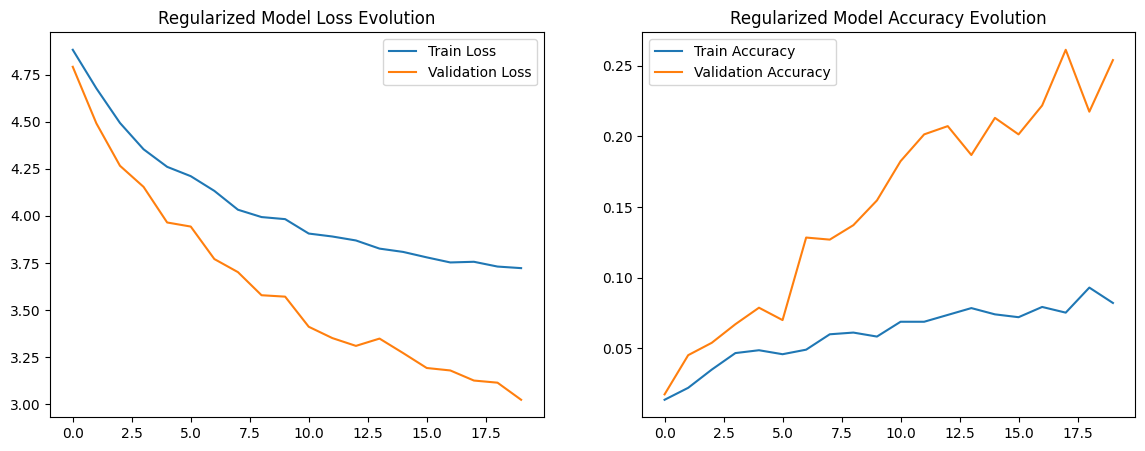

In [35]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Regularized Model Loss Evolution')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_reg.history['accuracy'], label='Train Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Regularized Model Accuracy Evolution')

plt.show()


In [37]:
# Initialize the performance dictionary with the performance of Model 1 (base CNN)
performance = {
    'Model': ['CNN Model 1'],
    'Training Accuracy': [max(history1.history['accuracy'])],
    'Validation Accuracy': [max(history1.history['val_accuracy'])],
    'Training Loss': [min(history1.history['loss'])],
    'Validation Loss': [min(history1.history['val_loss'])]
}

# Now, extend the performance dictionary with the performance of the regularized CNN model
performance['Model'].extend(['Regularized_CNN'])
performance['Training Accuracy'].extend([max(history_reg.history['accuracy'])])
performance['Validation Accuracy'].extend([max(history_reg.history['val_accuracy'])])
performance['Training Loss'].extend([min(history_reg.history['loss'])])
performance['Validation Loss'].extend([min(history_reg.history['val_loss'])])

# Update the performance dataframe
performance_df = pd.DataFrame(performance)
print(performance_df)



             Model  Training Accuracy  Validation Accuracy  Training Loss  \
0      CNN Model 1           0.932313             0.891971       0.213881   
1  Regularized_CNN           0.093070             0.261314       3.722505   

   Validation Loss  
0         0.389418  
1         3.022817  


### Compare model performance against base CNN model

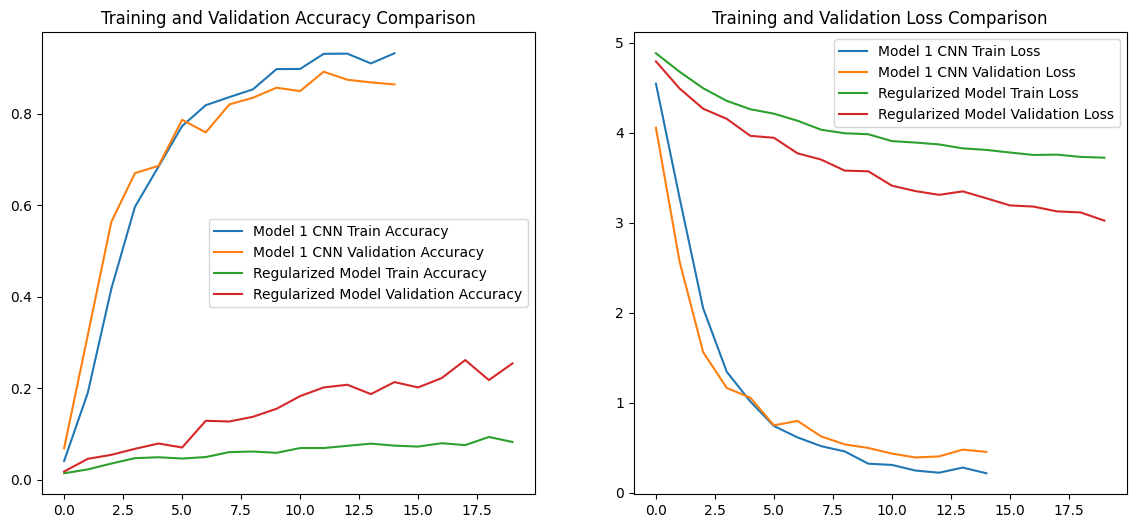

In [39]:
plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 CNN Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Model 1 CNN Validation Accuracy')
plt.plot(history_reg.history['accuracy'], label='Regularized Model Train Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Regularized Model Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 CNN Train Loss')
plt.plot(history1.history['val_loss'], label='Model 1 CNN Validation Loss')
plt.plot(history_reg.history['loss'], label='Regularized Model Train Loss')
plt.plot(history_reg.history['val_loss'], label='Regularized Model Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()

plt.show()


In [40]:
# Create a dictionary with the performance metrics of each model
performance_compare = {
    'Model': ['CNN Model 1', 'Regularized CNN'],
    'Training Accuracy': [
        max(history1.history['accuracy']),
        max(history_reg.history['accuracy']),
    ],
    'Validation Accuracy': [
        max(history1.history['val_accuracy']),
        max(history_reg.history['val_accuracy']),
    ],
    'Training Loss': [
        min(history1.history['loss']),
        min(history_reg.history['loss']),
    ],
    'Validation Loss': [
        min(history1.history['val_loss']),
        min(history_reg.history['val_loss']),
    ]
}

# Transform the dictionary into a pandas dataframe
performance_compare_df = pd.DataFrame(performance_compare)
print(performance_compare_df)


             Model  Training Accuracy  Validation Accuracy  Training Loss  \
0      CNN Model 1           0.932313             0.891971       0.213881   
1  Regularized CNN           0.093070             0.261314       3.722505   

   Validation Loss  
0         0.389418  
1         3.022817  


In [55]:
performance_compare_df

,Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,CNN Model 1,0.932313,0.891971,0.213881,0.389418
1,Regularized CNN,0.093070,0.261314,3.722505,3.022817


### We'll further look at precision, recall, or the F1 score for both the model to make sure avoid the potential issue of imbalanced class

In [41]:
from tensorflow.keras.metrics import Precision, Recall

precision = Precision()
recall = Recall()

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

history1 = model1.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/20
78/78 [==============================] - 40s 503ms/step - loss: 0.2811 - accuracy: 0.9085 - precision: 0.9263 - recall: 0.8864 - val_loss: 0.5395 - val_accuracy: 0.8409 - val_precision: 0.8817 - val_recall: 0.8161
Epoch 2/20
78/78 [==============================] - 38s 485ms/step - loss: 0.2418 - accuracy: 0.9178 - precision: 0.9336 - recall: 0.9009 - val_loss: 0.4573 - val_accuracy: 0.8628 - val_precision: 0.9000 - val_recall: 0.8409
Epoch 3/20
78/78 [==============================] - 42s 542ms/step - loss: 0.2077 - accuracy: 0.9319 - precision: 0.9459 - recall: 0.9226 - val_loss: 0.3852 - val_accuracy: 0.8934 - val_precision: 0.9201 - val_recall: 0.8745
Epoch 4/20
78/78 [==============================] - 34s 436ms/step - loss: 0.1647 - accuracy: 0.9464 - precision: 0.9580 - recall: 0.9367 - val_loss: 0.3993 - val_accuracy: 0.8934 - val_precision: 0.9146 - val_recall: 0.8759
Epoch 5/20
78/78 [==============================] - 36s 462ms/step - loss: 0.1607 - accuracy: 0.9484

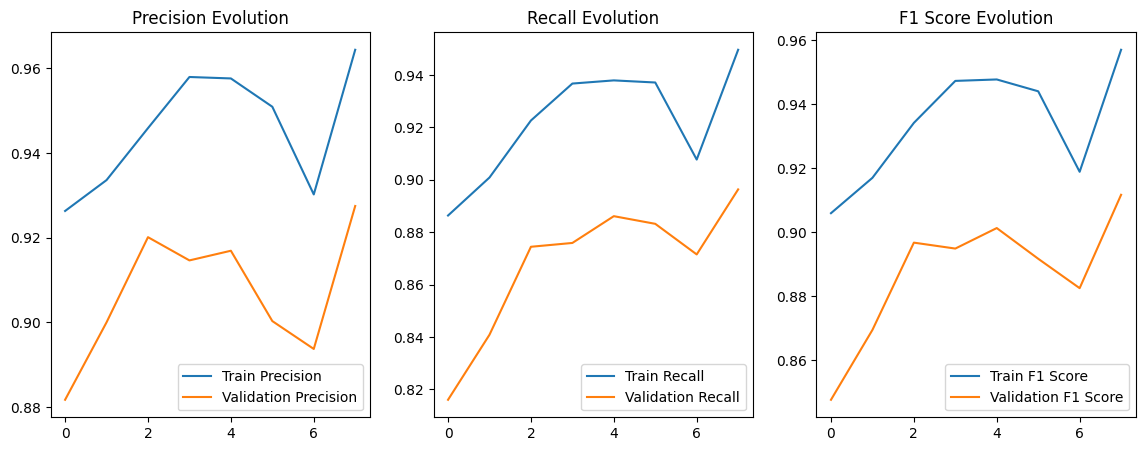

In [42]:
precision = history1.history['precision']
val_precision = history1.history['val_precision']

recall = history1.history['recall']
val_recall = history1.history['val_recall']

f1_score = [2 * (p * r) / (p + r) if p + r != 0 else 0 for p, r in zip(precision, recall)]
val_f1_score = [2 * (p * r) / (p + r) if p + r != 0 else 0 for p, r in zip(val_precision, val_recall)]

plt.figure(figsize=(14, 5))

# Plot precision, recall and f1_score
plt.subplot(1, 3, 1)
plt.plot(precision, label='Train Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend()
plt.title('Precision Evolution')

plt.subplot(1, 3, 2)
plt.plot(recall, label='Train Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend()
plt.title('Recall Evolution')

plt.subplot(1, 3, 3)
plt.plot(f1_score, label='Train F1 Score')
plt.plot(val_f1_score, label='Validation F1 Score')
plt.legend()
plt.title('F1 Score Evolution')

plt.show()


### Regularized CNN model with added L2 regularization:

In [43]:
from tensorflow.keras import regularizers

reg_lambda = 0.01

model_reg = Sequential()

model_reg.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(reg_lambda), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Dropout(0.25))

model_reg.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(reg_lambda)))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Dropout(0.25))

model_reg.add(Flatten())
model_reg.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_lambda)))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(num_classes, activation='softmax'))

model_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_reg = model_reg.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/20
78/78 [==============================] - 40s 500ms/step - loss: 5.8532 - accuracy: 0.0133 - val_loss: 4.9617 - val_accuracy: 0.0219
Epoch 2/20
78/78 [==============================] - 40s 503ms/step - loss: 4.7109 - accuracy: 0.0379 - val_loss: 4.3855 - val_accuracy: 0.0584
Epoch 3/20
78/78 [==============================] - 39s 500ms/step - loss: 4.3382 - accuracy: 0.0508 - val_loss: 4.0015 - val_accuracy: 0.0949
Epoch 4/20
78/78 [==============================] - 38s 481ms/step - loss: 4.1212 - accuracy: 0.0548 - val_loss: 3.7095 - val_accuracy: 0.1343
Epoch 5/20
78/78 [==============================] - 39s 499ms/step - loss: 3.9185 - accuracy: 0.0786 - val_loss: 3.5137 - val_accuracy: 0.1489
Epoch 6/20
78/78 [==============================] - 41s 519ms/step - loss: 3.7901 - accuracy: 0.0971 - val_loss: 3.2768 - val_accuracy: 0.2131
Epoch 7/20
78/78 [==============================] - 39s 494ms/step - loss: 3.6620 - accuracy: 0.0995 - val_loss: 3.1417 - val_accuracy: 0.2292

In [44]:
# Generate predictions
y_pred_reg = model_reg.predict(test_generator)


22/22 [==============================] - 4s 167ms/step


In [45]:
# Convert predictions to classes
y_pred_reg_classes = np.argmax(y_pred_reg, axis=1)


In [46]:
y_true = test_generator.classes


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_reg = precision_score(y_true, y_pred_reg_classes, average='weighted')
recall_reg = recall_score(y_true, y_pred_reg_classes, average='weighted')
f1_reg = f1_score(y_true, y_pred_reg_classes, average='weighted')

print('Precision: ', precision_reg)
print('Recall: ', recall_reg)
print('F1 score: ', f1_reg)


Precision:  0.015741557712360632
Recall:  0.017518248175182483
F1 score:  0.015568242744577744


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# Generate predictions for original CNN model
y_pred_orig = model1.predict(test_generator)

# Convert predictions to classes
y_pred_orig_classes = np.argmax(y_pred_orig, axis=1)


22/22 [==============================] - 7s 293ms/step


In [49]:
# Generate predictions for original CNN model
y_pred_orig = model1.predict(test_generator)

# Convert predictions to classes
y_pred_orig_classes = np.argmax(y_pred_orig, axis=1)


22/22 [==============================] - 3s 151ms/step


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_orig = precision_score(y_true, y_pred_orig_classes, average='weighted')
recall_orig = recall_score(y_true, y_pred_orig_classes, average='weighted')
f1_orig = f1_score(y_true, y_pred_orig_classes, average='weighted')

print('Original model precision: ', precision_orig)
print('Original model recall: ', recall_orig)
print('Original model F1 score: ', f1_orig)


Original model precision:  0.0051094890510948905
Original model recall:  0.00583941605839416
Original model F1 score:  0.00535279805352798


In [52]:
comparison_df = pd.DataFrame({
    'Model': ['Original CNN', 'Regularized CNN'],
    'Precision': [precision_orig, precision_reg],
    'Recall': [recall_orig, recall_reg],
    'F1 Score': [f1_orig, f1_reg]
})

print(comparison_df)


             Model  Precision    Recall  F1 Score
0     Original CNN   0.005109  0.005839  0.005353
1  Regularized CNN   0.015742  0.017518  0.015568


In [53]:
comparison_df

,Model,Precision,Recall,F1 Score
0,Original CNN,0.005109,0.005839,0.005353
1,Regularized CNN,0.015742,0.017518,0.015568


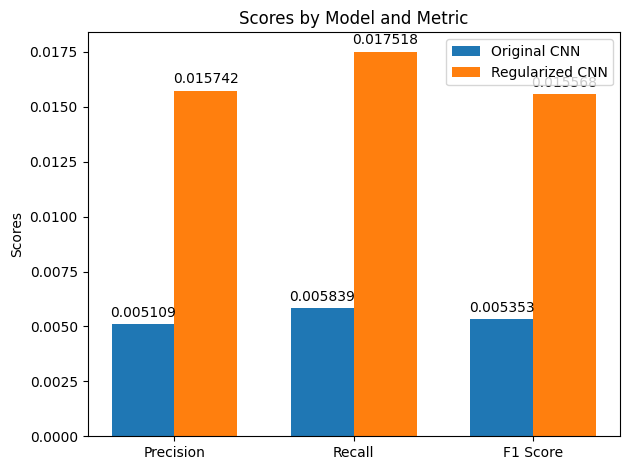

In [63]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Precision', 'Recall', 'F1 Score']
original_CNN_scores = [0.005109, 0.005839, 0.005353]
regularized_CNN_scores = [0.015742, 0.017518, 0.015568]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_CNN_scores, width, label='Original CNN')
rects2 = ax.bar(x + width/2, regularized_CNN_scores, width, label='Regularized CNN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# To add labels above bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()
